# Decision Tree Model

In [16]:
import pandas as pd  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import time

In [17]:
# Read Dataset
data_path = "results_feature_grid.txt"
with open(data_path, "r") as file:
    lines = file.readlines()

distanceList = []
intensityList = []
stdList = []
for line in lines[9:]:
    line = line.split()
    distanceList.append(float(line[0]))
    intensityList.append(float(line[1]))
    stdList.append(float(line[2]))

data = {
    'distance': distanceList, 
    'intensity': intensityList, 
    'std': stdList
}
df = pd.DataFrame(data)  

# Define features and target variable  
X = df[['distance', 'intensity']]  
y = df['std']  

# Split the dataset into training and testing sets  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

# Initialize and train the Random Forest Regressor model  
model = RandomForestRegressor(n_estimators=100, random_state=42)
begin_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print(f'Training Time: {end_time - begin_time}')

# Make predictions  
y_pred = model.predict(X_test)  

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Mean Squared Error: {rmse}')  

# Print predicted and actual results  
# print('Predicted Intensity:', y_pred)  
# print('Actual Intensity:', y_test.values)

Training Time: 0.10497355461120605
Mean Squared Error: 0.028730682749869205


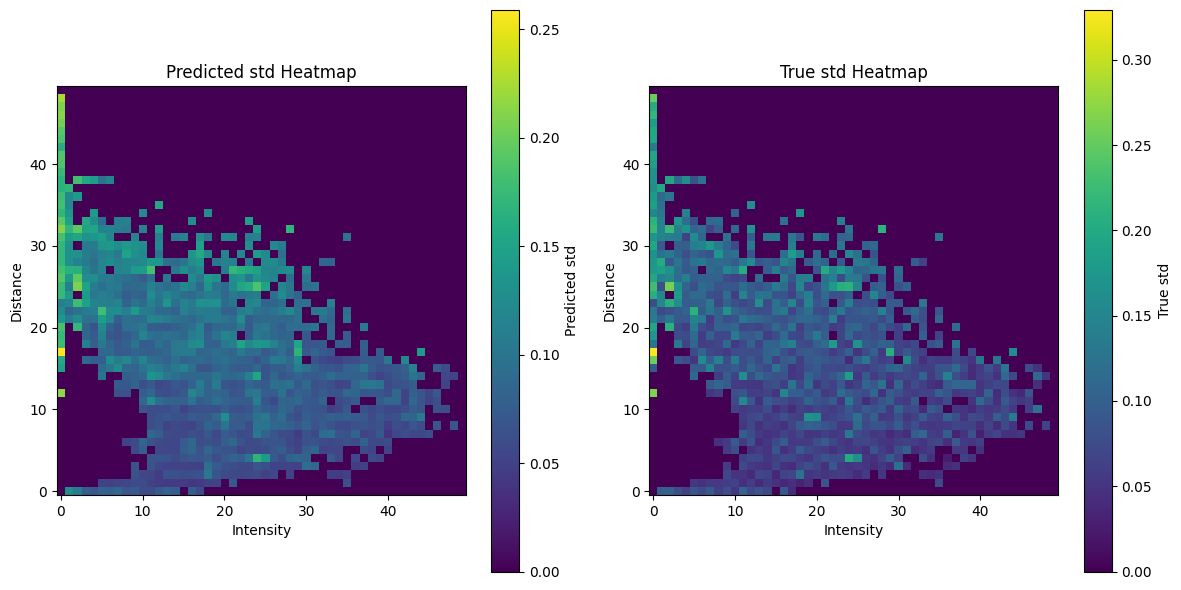

In [18]:
from scipy.stats import binned_statistic_2d

y_pred = model.predict(X)

# 定义Bin的数量  
N = 50

# 创建x和y的边界
maxBinDistance = float(lines[4].split()[1])
minBinDistance = float(lines[5].split()[1])
maxBinIntensity = float(lines[6].split()[1])
minBinIntensity = float(lines[7].split()[1])
stepDistance = (maxBinDistance - minBinDistance) / N
binsDistance = np.arange(minBinDistance, maxBinDistance, stepDistance)
stepIntensity = (maxBinIntensity - minBinIntensity) / N
binsIntensity = np.arange(minBinIntensity, maxBinIntensity, stepIntensity)
stdGridTrue = np.zeros((N, N))
stdGridPred = np.zeros((N, N))

# 计算每个bin的平均值
for j in range(N - 1):
    for i in range(N - 1):
        mask = (X['distance'] >= binsDistance[j]) & (X['distance'] < binsDistance[j + 1]) & (X['intensity'] >= binsIntensity[i]) & (X['intensity'] < binsIntensity[i + 1])
        if np.sum(mask) == 0:
            continue
        stdGridTrue[i, j] = np.mean(y[mask])
        stdGridPred[i, j] = np.mean(y_pred[mask])

# 绘制热力图  
plt.figure(figsize=(12, 6))  

# 预测值热力图  
plt.subplot(1, 2, 1)  
plt.imshow(stdGridPred.T, origin='lower', cmap='viridis')
plt.colorbar(label='Predicted std')  
plt.xlabel('Intensity')  
plt.ylabel('Distance')  
plt.title('Predicted std Heatmap')  

# 真实值热力图  
plt.subplot(1, 2, 2)  
plt.imshow(stdGridTrue.T, origin='lower', cmap='viridis')
plt.colorbar(label='True std')  
plt.xlabel('Intensity')  
plt.ylabel('Distance')  
plt.title('True std Heatmap')  

plt.tight_layout()  
plt.show()  